In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
import numpy as np
from pprint import pprint
import pathlib as pl
import torchaudio
import whisper
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import Audio

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import (
    LlamaTokenizer,
    MistralConfig,
    MistralForCausalLM,
)
import torch
from torch.utils.data import DataLoader
import pathlib as pl

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, GenerationConfig

import torch
torch.backends.cuda.matmul.allow_tf32 = True

from src2.voixdb import util
from src2.voixdb.util import *
from src2.voixdb.dataset.music_caps import (
    MusicCapsDataset,
    load_csv,
)
from src2.voixdb.model import Model, TunableWhisperAudioEncoder, load_llm
from src2.voixdb.train import Trainer
from src2.voixdb.train_cfg import TrainerCfg


In [3]:
# !pip install datasets

In [4]:
# import whisper

# import torch
# from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
# from datasets import load_dataset


# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# model_id = "openai/whisper-large-v3"

# model = AutoModelForSpeechSeq2Seq.from_pretrained(
#     model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
# )
# model.to(device)

In [5]:
# from tqdm import tqdm
# with torch.no_grad():
#     with torch.amp.autocast(device_type="cuda",dtype=torch.float16):
#             [audio_encoder(util.load_audio_mels(entry["file"]).cuda()).cpu() for entry in tqdm(train_entries)]

In [6]:
import numpy as np
import random
import os
import torch

# Set seed for everything
seed = 1337
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [7]:
# Access the values of the arguments
tr_cfg = TrainerCfg(
    epoch=1,
    model_save_freq=1,
    device="cuda:0",
    model_out_dir="/root/out-model",
)

stage = "proj" # vs. "peft"

class DummyEncoder(nn.Module):
    a=1
whisper_encoder = None#DummyEncoder() # set to None to auto-load it.

audio_encoder = TunableWhisperAudioEncoder(audio_encoder=whisper_encoder) # it's not None, but I don't wanna load a heavy encoder
if stage == "peft":
    audio_encoder.proj.load_state_dict(torch.load("model_manual_save4.pth"))
    for param in audio_encoder.proj.parameters():
        param.requires_grad = False
        pass

audio_encoder.to(tr_cfg.device)

tokenizer,llm = load_llm()
model = Model(audio_encoder.to(torch.bfloat16), llm)

from peft import get_peft_model, prepare_model_for_int8_training,LoraConfig
if stage == "peft":

    # PEFT config
    lora_alpha = 16
    lora_dropout = 0.1
    lora_r = 64
    peft_config = LoraConfig(
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        r=lora_r,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=["k_proj", "q_proj", "v_proj", "up_proj", "down_proj", "gate_proj"]
    )
    model.llm = get_peft_model(model.llm, peft_config)

# print fraction of trainable params
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
fraction_trainable = trainable_params / total_params
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Fraction of parameters that are trainable: {fraction_trainable:.2%}")

entries = load_csv(load_raw=False)
train_size = int(len(entries) * 0.9)
train_entries = entries[:train_size]
eval_entries = entries[train_size:]

max_length = 400

embed_tokens = llm.model.embed_tokens
torch.save(embed_tokens.state_dict(),"embed.pt")
raw_embedding = nn.Embedding(embed_tokens.num_embeddings,embed_tokens.embedding_dim)
raw_embedding.load_state_dict(embed_tokens.state_dict())
raw_embedding.cpu()

eval_ds = MusicCapsDataset(eval_entries, tokenizer, util.prompt_template_fn,audio_encoder.audio_encoder,raw_embedding,max_length,key="eval-audio")
eval_dl = DataLoader(eval_ds, batch_size=1, shuffle=True, num_workers=6)

train_ds = MusicCapsDataset(train_entries, tokenizer, util.prompt_template_fn,audio_encoder.audio_encoder,raw_embedding,max_length,key="train-audio")
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=12)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Error during conversion: ValueError('Queue is full! Please try again.')


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Total parameters: 4392381952
Trainable parameters: 5245440
Fraction of parameters that are trainable: 0.12%


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# counts, bins = np.histogram(list(train_ds.raw_sizes))
# plt.stairs(counts, bins)

In [9]:
# row = train_ds[0]
# row['input_embeds_raw'][:,0]

In [10]:
# verify model weight
from collections import Counter
pbytype = Counter()
for name, p in (model.named_parameters()):
    if torch.isinf(p).any() or torch.isnan(p).any():
        print(name, p)
        raise ValueError("invalid weight")
    else:
        pbytype[p.dtype] += 1
print("OK", pbytype)

OK Counter({torch.bfloat16: 489, torch.uint8: 224, torch.float16: 67})


In [11]:
# means = []
# stds = []
# norms = []
# for name, p in (model.audio_encoder.audio_encoder.named_parameters()):
#     if p.dim() == 2:
#         print(p.dtype)
#         print(p.max().item(), p.min().item())

#         means.append(p.mean().item())
#         stds.append(p.std().item())
#         norms.append(torch.linalg.norm(p.to(torch.float).cpu().detach()))
        
# plt.hist(means, bins=100, color='blue', alpha=0.7)

In [12]:
# norms = []
# means = []
# stds = []

# for name, p in (model.audio_encoder.proj.named_parameters()):
#     print(p.dtype)
#     print(p.max().item(), p.min().item())
#     means.append(p.mean().item())
#     stds.append(p.std().item())
#     norms.append(torch.linalg.norm(p.to(torch.float).cpu().detach()))

# plt.hist(means, bins=100, color='red', alpha=0.7)

In [13]:
@torch.no_grad
def sampler(input_ids):
    outputs = []
    for _ in range(50):
        inputs_embeds = model.llm.model.embed_tokens(input_ids)
        res = model.llm(inputs_embeds=inputs_embeds)
        sampled = torch.multinomial(res.logits[:,-1,:].softmax(dim=-1), 1)# .to(device)
        input_ids = torch.cat((input_ids, sampled), dim=-1)
    return input_ids
        

In [14]:
# tokenizer.decode(sampler(tokenizer("tell me a story", return_tensors="pt").input_ids.to(tr_cfg.device))[0])

In [15]:
import torch.optim as optim

lr_default = 2e-3
adam_beta1 = 0.9
adama_beta2 = 0.999
adam_eps = 1e-8

# TODO: experiment with AdamW
optimizer = optim.Adam(
    [*model.parameters(),nn.Parameter(torch.tensor(1.0))],
    lr=lr_default,
    betas=(adam_beta1, adama_beta2),
    eps=adam_eps,
)
datagen = iter(train_dl)
device = tr_cfg.device
uds = []
losses = []

In [16]:
# from src2.voixdb.dataset.music_caps import MusicCapsDataset
# train_ds = MusicCapsDataset(train_entries, tokenizer, util.prompt_template_fn,audio_encoder.audio_encoder,raw_embedding,max_length,key="train-audio")
# train_dl = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1)
# datagen = iter(train_dl)

# from time import perf_counter
# start_time = perf_counter()
# for i in range(3):
#     b = next(datagen)

# time_per_iter = (perf_counter() - start_time) / 20

# time_per_iter
# # raise 1

In [17]:
{k:v.shape for k,v in train_ds[0].items() if torch.is_tensor(v)}

{'attention_mask': torch.Size([400]),
 'input_embeds_raw': torch.Size([400, 4096]),
 'input_ids_raw': torch.Size([400]),
 'audio_embeds_raw': torch.Size([2000, 1280]),
 'audio_tokens_start': torch.Size([]),
 'audio_tokens_end': torch.Size([]),
 'cap_tokens_start': torch.Size([]),
 'n_audio_embeds': torch.Size([])}

In [18]:
inputs_embeds = None
attention_mask = None
batch = None

def fwd(self, _batch):
    global inputs_embeds,attention_mask,batch
    batch = _batch
    attention_mask = batch["attention_mask"]
    inputs_embeds = batch["input_embeds_raw"].clone()
    audio_embeds_raw = batch["audio_embeds_raw"]

    audio_start = batch["audio_tokens_start"]
    audio_end = batch["audio_tokens_end"]

    n_audio_embeds = batch["n_audio_embeds"]

    # print({k:v.shape for k,v in batch.items()})

    # un-pad and project the audio embeddings separately
    audio_embeds = torch.stack([self.audio_encoder.proj(audio_embeds_raw[i,-n_audio_embeds[i]:]) for i in range(len(n_audio_embeds))])
    assert audio_embeds.shape[1] == 250,f"shape is {audio_embeds.shape}"

    N,*_ = audio_embeds.shape
    for i in range(N):
        # print(inputs_embeds.shape,audio_start[i],audio_end[i],audio_embeds.shape,audio_embeds_raw.shape)
        # print("curr_embeds",inputs_embeds[i,audio_start[i]:audio_end[i]])
        inputs_embeds[i,audio_start[i]:audio_end[i]] = audio_embeds[i]
    
    # print('cap_embeds', cap_embeds.mean(dim=1), cap_embeds.std(dim=1))
    mout = self.llm(
        inputs_embeds=inputs_embeds,
        # output_attentions=True,
        # output_hidden_states=True,
        attention_mask=attention_mask,
        # use_cache=False,
    )

    return mout, audio_embeds.shape[1]

In [19]:
local_batch = next(datagen)
batch = {
    k: v.to(device)
    for k, v in local_batch.items()
    if not k.startswith("_")
}
with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
    fwd(model,batch)
# raise 1

In [20]:
attention_mask

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.,

In [21]:
inputs_embeds[:,:,0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -4.5776e-03,  6.2180e-04,
         -9.9182e-04, -1.0910e-03,  1.7071e-04,  2.0142e-03,  3.7193e-04,
          3.7384e-04, -7.5073e-03, -2.2697e-04, -6.3705e-04,  1.8997e-03,
          1.4725e-03,  8.7738e-04,  2.0264e-02,  6.2180e-04, -5.8365e-04,
         -1.0910e-03,  1.7071e-04,  3.0975e-03,  3.0327e-04,  1.9531e-03,
         -6.3324e-04,  3.0327e-04,  6.0272e-04, -1.0757e-03, -5.1221e-01,
         -5.0049e-01, -5.7422e-01, -4.4043e-01, -2.8336e-02,  1.4490e-01,
          4.8431e-02,  1.2939e-01,  8.

In [22]:
batch["audio_embeds_raw"][:,-1500:]

tensor([[[-0.3455,  0.0757, -0.3291,  ..., -0.3503, -0.8652, -0.1144],
         [-0.0167, -0.5898, -0.1451,  ..., -0.6885,  0.1315,  0.3777],
         [-0.1514, -0.4700, -0.1904,  ..., -0.5703, -0.1037, -0.1613],
         ...,
         [-0.4099, -0.2766, -0.3994,  ...,  0.3489, -0.2136, -1.2627],
         [-0.3816,  0.3508, -0.6006,  ...,  0.4104, -0.2983, -1.9473],
         [-0.1212,  0.6753, -0.5586,  ...,  0.4846,  0.1449, -0.7954]]],
       device='cuda:0')

In [23]:
with torch.no_grad():
    with torch.amp.autocast(device_type="cuda",dtype=torch.float16):
        a=audio_encoder.audio_encoder(util.load_audio_mels(train_ds.entries[0]["file"]).cuda())
a

tensor([[[-0.4104,  0.0649,  0.5522,  ..., -0.1167, -0.3240, -0.6045],
         [ 0.1138, -0.9551, -0.2742,  ..., -0.4602, -0.3120, -0.3083],
         [ 0.0380, -0.3933, -0.4968,  ..., -0.1611, -0.2249, -0.3965],
         ...,
         [-0.4922, -0.2446, -0.2267,  ...,  0.0430, -0.1564, -1.2529],
         [-0.3904,  0.3357, -0.4678,  ...,  0.2822, -0.4429, -1.5586],
         [-0.1785,  0.7549, -0.4580,  ...,  0.3855,  0.0160, -0.4167]]],
       device='cuda:0', dtype=torch.float16)

In [24]:
# torch.sum(batch["attention_mask"][1] != 0)

In [25]:
# train_ds.raw_audio_embeds[0].shape

In [26]:
# targets[0]
# tokenizer.decode(targets[0,-84:])
# tokenizer.decode(torch.max(logits[0,-84:],dim=-1).indices)
# with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
#     b = model.audio_encoder.proj(batch["audio_embeds_raw"][0,-batch["n_audio_embeds"][0]:])
# b
# print(batch["n_audio_embeds"][0])
# print(torch.sum(batch["audio_embeds_raw"][0,:,0]!=0),batch["audio_embeds_raw"].shape)



In [27]:
def get_loss(local_batch):
    # Transfer to GPU
    batch = {
        k: v.to(device)
        for k, v in local_batch.items()
        if not k.startswith("_")
    }
    # compute
    with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
        mout, audio_seq = fwd(model, batch)

    targets = batch["input_ids_raw"][:]
    target_idxes = torch.arange(max_length,device=targets.device)[None]

    # remove the last output
    logits = mout.logits
    logits_start = batch["cap_tokens_start"].to(targets.device)

    # print()
    targets = torch.masked_fill(targets,target_idxes < logits_start[:,None],-100)[:,1:].long()
    
    # remove the prompt and audio seq from logits
    # calculation; additionally, remove the final item
    logits = logits[:, :-1, :].contiguous().to(targets.device)

    # logits = logits[:,-20:]
    # targets = targets[:,-20:]
    assert logits.shape[:2] == targets.shape[:2], f"shape is {logits.shape} and {targets.shape}"
    # print(logits.shape,targets.shape)

    loss = nn.functional.cross_entropy(
        logits.view(-1, logits.shape[-1]), targets.view(-1)
    )

    return loss


In [28]:
from tqdm import tqdm
# taken from https://gist.github.com/Tony-Y/03e47588bae2e2bfd69815d046d994ec
import pytorch_warmup as warmup

epochs = 50
steps_per_epoch = len(train_dl)
warmup_period = 1000
num_steps = steps_per_epoch * epochs - warmup_period
t0 = num_steps // 3 # first cosine anneal

lr_min = 3e-5
max_step = t0 * 3 + warmup_period

lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=t0, T_mult=1, eta_min=lr_min)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


for _ in range(50):
    for i, local_batch in enumerate(train_dl):
        loss = get_loss(local_batch)

        # required to access grad on non leaf nodes
        for p in model.audio_encoder.proj.parameters():
            if p.requires_grad:
                p.retain_grad()
        
        # print("lossed")
    
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()


        with warmup_scheduler.dampening():
            if warmup_scheduler.last_step + 1 >= warmup_period:
                lr_scheduler.step()
        if warmup_scheduler.last_step + 1 >= max_step:
            break

        # print("backwarded")
        
        with torch.no_grad():
            ud = []
            for name, p in model.audio_encoder.proj.named_parameters():
                if not p.requires_grad or p.grad is None:
                    continue
                # if i % 10 == 0:
                #    print(name, p.grad.mean().item(), p.grad.std().item())
                ud.append(((lr_default*p.grad).std() / p.data.std()).log10().item())
            uds.append(ud)
            
        
        losses.append(loss.detach().cpu())
        del loss
        if i % 500 == 0:
            eval_losses = []
            with torch.no_grad():
                for local_batch in tqdm(eval_dl):
                    eval_loss = get_loss(local_batch)
                    eval_losses.append(eval_loss.cpu())
            print(f"{i}: train={np.mean(losses):.4f} eval={np.mean(eval_losses):.4f}")
            del eval_losses


100%|██████████| 493/493 [01:25<00:00,  5.74it/s]


0: train=9.0741 eval=9.0897


100%|██████████| 493/493 [01:26<00:00,  5.73it/s]


500: train=2.9610 eval=2.2764


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


1000: train=2.5896 eval=2.1614


100%|██████████| 493/493 [01:26<00:00,  5.73it/s]


1500: train=2.4386 eval=2.0546


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


2000: train=2.3381 eval=1.9921


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


2500: train=2.2767 eval=1.9612


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


3000: train=2.2197 eval=1.9113


100%|██████████| 493/493 [01:26<00:00,  5.73it/s]


3500: train=2.1787 eval=1.9021


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


4000: train=2.1484 eval=1.8839


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


0: train=2.1258 eval=1.8680


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


500: train=2.0923 eval=1.8387


100%|██████████| 493/493 [01:26<00:00,  5.73it/s]


1000: train=2.0652 eval=1.8390


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


1500: train=2.0444 eval=1.8319


100%|██████████| 493/493 [01:26<00:00,  5.73it/s]


2000: train=2.0250 eval=1.8255


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


2500: train=2.0085 eval=1.8233


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


3000: train=1.9949 eval=1.8127


100%|██████████| 493/493 [01:26<00:00,  5.71it/s]


3500: train=1.9822 eval=1.7980


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


4000: train=1.9699 eval=1.7955


100%|██████████| 493/493 [01:26<00:00,  5.71it/s]


0: train=1.9608 eval=1.7901


100%|██████████| 493/493 [01:26<00:00,  5.71it/s]


500: train=1.9441 eval=1.7936


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


1000: train=1.9302 eval=1.8135


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


1500: train=1.9178 eval=1.8013


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


2000: train=1.9070 eval=1.7939


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


2500: train=1.8969 eval=1.8036


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


3000: train=1.8865 eval=1.7831


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


3500: train=1.8792 eval=1.7747


100%|██████████| 493/493 [01:26<00:00,  5.71it/s]


4000: train=1.8709 eval=1.7787


100%|██████████| 493/493 [01:26<00:00,  5.71it/s]


0: train=1.8648 eval=1.7787


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


500: train=1.8525 eval=1.8186


100%|██████████| 493/493 [01:26<00:00,  5.71it/s]


1000: train=1.8416 eval=1.8113


100%|██████████| 493/493 [01:26<00:00,  5.71it/s]


1500: train=1.8316 eval=1.8123


100%|██████████| 493/493 [01:26<00:00,  5.73it/s]


2000: train=1.8223 eval=1.7992


100%|██████████| 493/493 [01:26<00:00,  5.71it/s]


2500: train=1.8147 eval=1.7974


100%|██████████| 493/493 [01:26<00:00,  5.73it/s]


3000: train=1.8074 eval=1.8012


100%|██████████| 493/493 [01:26<00:00,  5.72it/s]


3500: train=1.8019 eval=1.7818


100%|██████████| 493/493 [01:26<00:00,  5.71it/s]


4000: train=1.7949 eval=1.7879


100%|██████████| 493/493 [01:26<00:00,  5.70it/s]


0: train=1.7897 eval=1.7860


100%|██████████| 493/493 [01:26<00:00,  5.71it/s]


500: train=1.7798 eval=1.8365


100%|██████████| 493/493 [01:26<00:00,  5.70it/s]


1000: train=1.7709 eval=1.8571


100%|██████████| 493/493 [01:26<00:00,  5.71it/s]


1500: train=1.7621 eval=1.8386


 26%|██▌       | 128/493 [00:23<01:07,  5.41it/s]


KeyboardInterrupt: 

layer proj.weight | weight (4096, 1280) | mean +0.000000 | std 7.247925e-04 | grad:data ratio 1.599121e-02
layer ln1.weight | weight    (1280,) | mean -0.000029 | std 2.944946e-03 | grad:data ratio 6.523438e-01
layer ln1.bias | weight    (1280,) | mean +0.000074 | std 5.279541e-03 | grad:data ratio 7.519531e-02


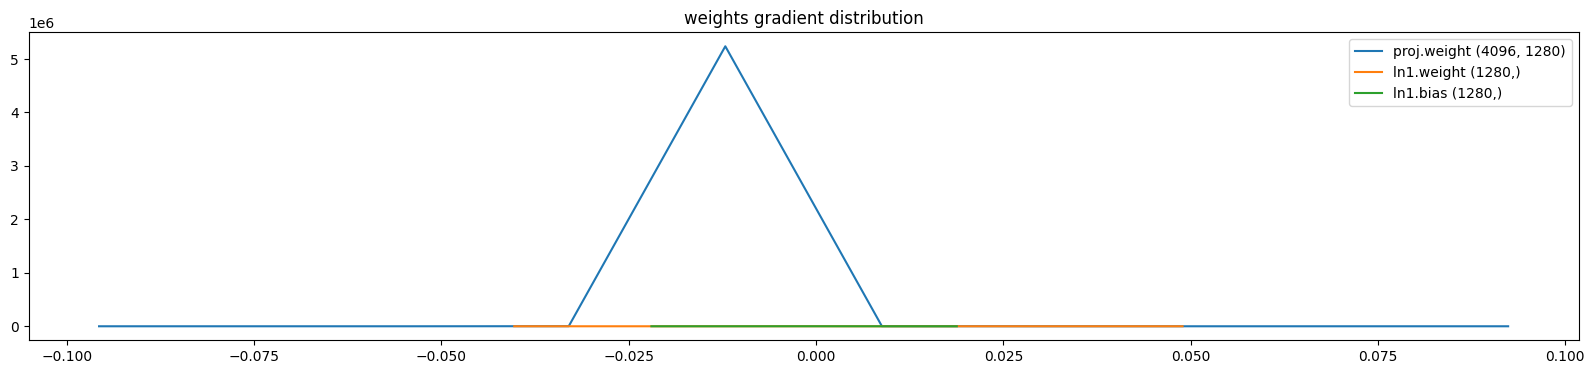

In [29]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
parameters = []
for i, l in enumerate([model.audio_encoder.proj]):
    #print('layer', l.__class__)
    for name, p in l.named_parameters():
        t = p.grad
        
        if t is None:
            continue

        print('layer %s | weight %10s | mean %+f | std %e | grad:data ratio %e' % (
            name, tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))

        hy, hx = np.histogram(t.to(torch.float32).cpu().detach().numpy())
        plt.plot(hx[:-1], hy)
        legends.append(f'{name} {tuple(p.shape)}')
            
plt.legend(legends)
plt.title('weights gradient distribution');

Text(0.5, 1.0, 'weight update relative to weight data, log scale')

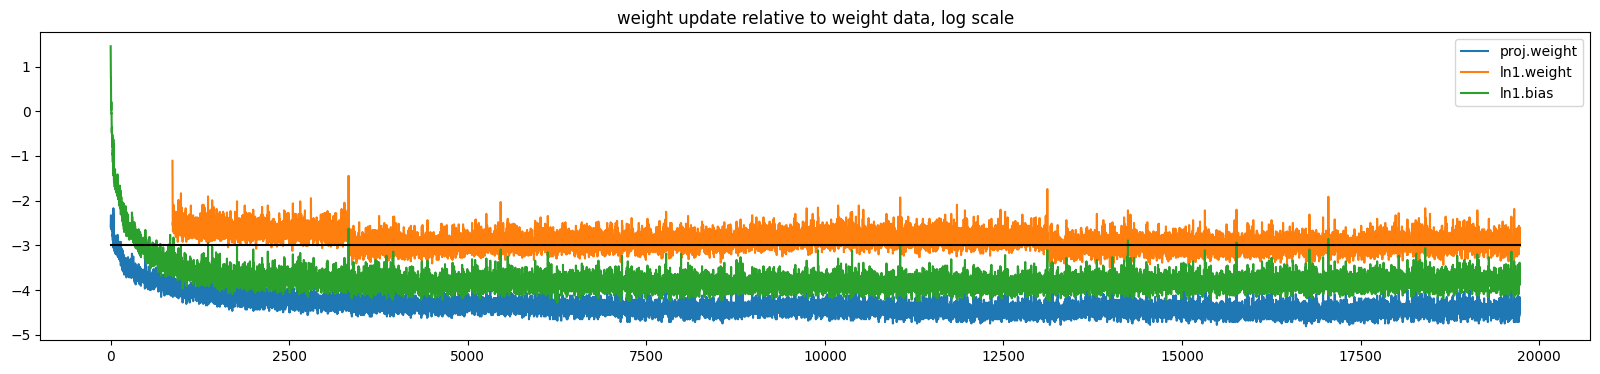

In [30]:
plt.figure(figsize=(20, 4))
legends = []
i = 0
for name, p in (model.audio_encoder.proj.named_parameters()):
    if p.grad is None:
        continue
    
    plt.plot([uds[epoch][i] for epoch in range(len(uds))])
    legends.append(name)

    i += 1
            
plt.plot([0, len(uds)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title("weight update relative to weight data, log scale")


In [32]:
l = torch.tensor(losses)

In [33]:
l[-50:].mean()

tensor(1.4351)

In [35]:
size_to_clip = l.size(0) - (l.size(0) % 100)
ml = l[:size_to_clip].reshape(-1, 100).mean(axis=1)


(0.0, 2.0)

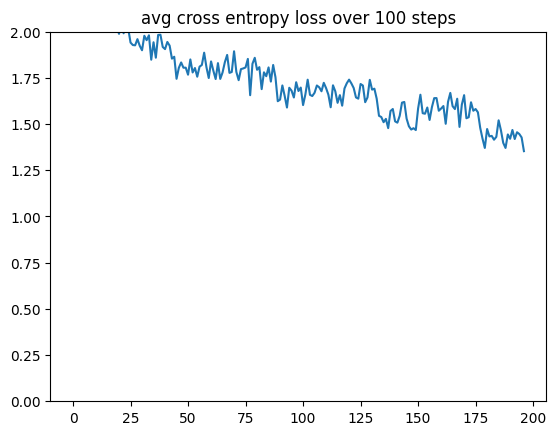

In [36]:
plt.plot(range((ml.shape[0])), ml.numpy())
plt.title("avg cross entropy loss over 100 steps")
plt.ylim(0, 2)

In [37]:
out = "model_manual_save5.pth"

torch.save(
    model.audio_encoder.proj.state_dict(),
    out,
)

In [44]:
from src2.voixdb.dataset.music_caps import MusicCapsDataset
eval_ds = MusicCapsDataset(eval_entries, tokenizer, util.prompt_template_fn,audio_encoder.audio_encoder,raw_embedding,max_length,key="eval-audio")
eval_dl = DataLoader(eval_ds, batch_size=1, shuffle=True, num_workers=1)
datagen=iter(eval_dl)

In [43]:
local_batch = next(datagen)
audio_file = local_batch["_id"][0][0]

print(tokenizer.decode(local_batch["input_ids_raw"][0]))
Audio(audio_file)

<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><s> <|im_start|>  system
    You are a helpful AI who follows instruction carefully<|im_end|> <|im_start|>  user
    Describe the sound of the given file<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><u

In [45]:
from src2.voixdb.util import sample_with_audio
tokenizer.decode(sample_with_audio(model, llm, tokenizer, prompt_template_fn(), audio_file, iteration=60)[0])

'<s> <|im_start|>  system\n    You are a helpful AI who follows instruction carefully<|im_end|> <|im_start|>  user\n    Describe the sound of the given file \n    <|im_end|> <|im_start|> assistant\n     The music features a male folk singer singing over a plucked stringed instrument. The song is upbeat and uptempo. The song has a danceable rhythm and is traditional folk dance music. The song is catchy and informal. The audio quality is generally good. The song can'

In [ ]:
import torch
import whisper

def prompt_template_fn(prompt="Describe the sound of the given file"):
    system_message = "You are a helpful AI who follows instruction carefully"

    prompt_prefix = f"""<|im_start|>system
    {system_message}<|im_end|>
    <|im_start|>user
    {prompt}"""

    return prompt_prefix


def end_template():
    return """
    <|im_end|>
    <|im_start|>assistant
    """


def load_audio_mels(file):
    audio = whisper.load_audio(file)
    audio = whisper.pad_or_trim(audio)
    audio_mels = whisper.log_mel_spectrogram(audio, n_mels=128)
    audio_mels = audio_mels.unsqueeze(0)
    return audio_mels


def text_2_ids_and_attention_mask(tokenizer, input_txt, truncate=False):
    txt = input_txt
    res = tokenizer(txt, return_tensors="pt")

    if truncate:
        return res.input_ids[:, 1:], res.attention_mask[:, 1:]

    return res.input_ids, res.attention_mask

@torch.no_grad()
def sample_with_audio(model, tokenizer, prompt, audio_file, device="cuda:0", iteration=50):
    audio_mels = load_audio_mels(audio_file).to(device).half()
    end_prompt_ids, end_prompt_attention_mask = text_2_ids_and_attention_mask(
        tokenizer,
        end_template(),
        truncate=True,
    )
    prompt_ids, prompt_attention_mask = text_2_ids_and_attention_mask(
        tokenizer,
        prompt,
    )

    prompt_ids = prompt_ids.to(device)
    prompt_attention_mask = prompt_attention_mask.to(device)
    end_prompt_attention_mask = end_prompt_attention_mask.to(device)
    end_prompt_ids = end_prompt_ids.to(device)
    sampled_ids = None

    prompt_embeds = None
    end_prompt_embeds = None
    audio_embeds = None

    with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
        if audio_embeds is None:
            audio_embeds = model.audio_encoder(audio_mels)
        bs, audio_seq = audio_embeds.shape[:2]
        
        mask_concat_args = [
            prompt_attention_mask,
            torch.ones(bs, audio_seq).to(audio_embeds.device),
            end_prompt_attention_mask,
        ]

        for _ in range(iteration):
            if sampled_ids is not None:
                mask_concat_args.append(torch.ones(bs, sampled_ids.shape[1]).to(audio_embeds.device))
                
            attention_mask = torch.concat(
                tuple(mask_concat_args),
                dim=1,
            )

            if prompt_embeds is None:
                prompt_embeds = model.llm.model.embed_tokens(prompt_ids)
            if end_prompt_embeds is None:
                end_prompt_embeds = model.llm.model.embed_tokens(end_prompt_ids)
                
            sampled_ids_embeds = None
            if sampled_ids is not None:
                sampled_ids_embeds = model.llm.model.embed_tokens(sampled_ids)
                
            embeds_concat_args = [
                prompt_embeds,
                audio_embeds.to(prompt_embeds.dtype),
                end_prompt_embeds,
            ]
            if sampled_ids_embeds is not None:
                embeds_concat_args.append(sampled_ids_embeds)
                
            inputs_embeds = torch.concat(
                tuple(embeds_concat_args),
                dim=1,
            )
    
            mout = model.llm(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
            )
    
            logits = mout.logits
            sampled = torch.multinomial(logits[:, -1, :].softmax(dim=-1), 1)
            
            if sampled_ids is None:
                sampled_ids = sampled
            else:
                sampled_ids = torch.cat((sampled_ids, sampled), dim=-1).to(device)

    # print(prompt_ids.shape)
    # print(end_prompt_ids.shape)
    # print(sampled_ids.shape)
    
    return torch.concat((
        prompt_ids, 
        end_prompt_ids,
        sampled_ids,
    ),dim=-1)
